In [1]:
from pyspark.sql import SparkSession

spark = SparkSession \
    .builder \
    .config("spark.dynamicAllocation.enabled", "false")\
    .config("spark.sql.adaptive.enabled", "false")\
    .config("spark.serializer", "org.apache.spark.serializer.KryoSerializer") \
    .appName("NYC TAXI ANALYSIS") \
    .master("local[4]")\
    .getOrCreate()

In [2]:
spark

In [3]:
taxi_DF = (
                  spark
                    .read 
                    .option("header",True)
                    .option("inferschema",True)
                    .csv("file:/home/jovyan/work/advanced_big_data/projects/ETL/marged_taxiData2.csv/")
              )

# Check number of partitions
print("Partitions = "    + str( taxi_DF.rdd.getNumPartitions() ))

# Check number of records
print("Record Count = "  + str( taxi_DF.count() ))

Partitions = 4
Record Count = 109679


In [4]:
taxi_DF.columns

['medallion',
 'rate_code',
 'pickup_datetime',
 'dropoff_datetime',
 'passenger_count',
 'trip_time_in_secs',
 'trip_distance',
 'pickUp_date_MilliS',
 'dropOff_date_MilliS',
 'duration',
 'duration_ByMin',
 'borough_area_code',
 'borough',
 'pickup_borough',
 'dropoff_borough']

In [5]:
taxi_DF.printSchema()

root
 |-- medallion: string (nullable = true)
 |-- rate_code: integer (nullable = true)
 |-- pickup_datetime: timestamp (nullable = true)
 |-- dropoff_datetime: timestamp (nullable = true)
 |-- passenger_count: integer (nullable = true)
 |-- trip_time_in_secs: integer (nullable = true)
 |-- trip_distance: double (nullable = true)
 |-- pickUp_date_MilliS: long (nullable = true)
 |-- dropOff_date_MilliS: long (nullable = true)
 |-- duration: integer (nullable = true)
 |-- duration_ByMin: double (nullable = true)
 |-- borough_area_code: integer (nullable = true)
 |-- borough: string (nullable = true)
 |-- pickup_borough: string (nullable = true)
 |-- dropoff_borough: string (nullable = true)



In [6]:
from pyspark.sql.functions import spark_partition_id ,count, sum, avg, stddev_pop,max, min,asc,desc,col,round


In [7]:
taxi_DF.groupBy(spark_partition_id()).count().orderBy("spark_partition_id()",ascending=True).show()

+--------------------+-----+
|SPARK_PARTITION_ID()|count|
+--------------------+-----+
|                   0|28322|
|                   1|27470|
|                   2|27293|
|                   3|26594|
+--------------------+-----+



In [8]:
def getDataFrameStats(dataFrame, columnName):

    outputDF = (
                    dataFrame

                        # Get partition number for each record
                        .withColumn("Partition Number", spark_partition_id())
        
        
                        # Group by partition, and calculate stats for a column
                        .groupBy("Partition Number")
                        .agg(
                                  count("*").alias("Record Count"),
                                  min(columnName).alias("Min Column Value"),
                                  max(columnName).alias("Max Column Value")
                            )

                        .orderBy("Partition Number")
               )

    return outputDF

In [9]:
getDataFrameStats(taxi_DF,"borough_area_code").show()

+----------------+------------+----------------+----------------+
|Partition Number|Record Count|Min Column Value|Max Column Value|
+----------------+------------+----------------+----------------+
|               0|       28322|               1|               5|
|               1|       27470|               1|               5|
|               2|       27293|               1|               5|
|               3|       26594|               1|               5|
+----------------+------------+----------------+----------------+



In [14]:
# Check duplicates 
taxi_DF.groupby("medallion", "pickup_datetime")\
.count()\
.filter(col('count') > 1).show(10)

+--------------------+-------------------+-----+
|           medallion|    pickup_datetime|count|
+--------------------+-------------------+-----+
|079E2EE80E3CFA17E...|2013-01-13 04:34:00|    2|
|F2656117E0FEC6FA6...|2013-01-13 04:06:00|    2|
|418E2E585E5369B5A...|2013-01-13 01:22:00|    2|
|652979D8BB6F2409F...|2013-01-13 05:59:00|    2|
|6F70168FE64F69314...|2013-01-13 04:52:00|    2|
|19805AB6F3EC7675A...|2013-01-13 06:52:00|    2|
|FED8DEEA16C86B89B...|2013-01-13 10:21:00|    2|
|6E02AE5834F1FA04E...|2013-01-13 11:06:00|    2|
|62099C3783738399C...|2013-01-13 04:36:00|    2|
|7E3BF2C5869112F39...|2013-01-13 03:19:00|    2|
+--------------------+-------------------+-----+
only showing top 10 rows



In [26]:
print(f"""Number of Duplicated Records: {taxi_DF.groupby('medallion', 'pickup_datetime').count().filter(col('count') > 1).count()}""")

Number of Duplicated Records: 11485


In [27]:
taxi_DF=taxi_DF.dropDuplicates(['medallion', 'pickup_datetime'])

In [29]:
taxi_DF.groupby("medallion", "pickup_datetime")\
.count()\
.filter(col('count') > 1).show()

+---------+---------------+-----+
|medallion|pickup_datetime|count|
+---------+---------------+-----+
+---------+---------------+-----+



In [30]:
taxi_DF.count()

98194

In [31]:
taxi_DF.select("pickup_borough","dropoff_borough").show()

+--------------+---------------+
|pickup_borough|dropoff_borough|
+--------------+---------------+
|     Manhattan|      Manhattan|
|     Manhattan|      Manhattan|
|     Manhattan|      Manhattan|
|     Manhattan|      Manhattan|
|     Manhattan|      Manhattan|
|     Manhattan|      Manhattan|
|     Manhattan|      Manhattan|
|     Manhattan|      Manhattan|
|     Manhattan|      Manhattan|
|     Manhattan|      Manhattan|
|        Queens|         Queens|
|     Manhattan|      Manhattan|
|          NULL|         Queens|
|     Manhattan|      Manhattan|
|     Manhattan|      Manhattan|
|     Manhattan|      Manhattan|
|          NULL|       Brooklyn|
|        Queens|           NULL|
|     Manhattan|      Manhattan|
|     Manhattan|      Manhattan|
+--------------+---------------+
only showing top 20 rows



#### Fill null value in pickup_borough and dropoff_borough with "unknown"

In [33]:
taxi_DF.na.fill(value="Unknown",subset=["pickup_borough","dropoff_borough"]).select("pickup_borough","dropoff_borough").show()


+--------------+---------------+
|pickup_borough|dropoff_borough|
+--------------+---------------+
|     Manhattan|      Manhattan|
|     Manhattan|      Manhattan|
|     Manhattan|      Manhattan|
|     Manhattan|      Manhattan|
|     Manhattan|      Manhattan|
|     Manhattan|      Manhattan|
|     Manhattan|      Manhattan|
|     Manhattan|      Manhattan|
|     Manhattan|      Manhattan|
|     Manhattan|      Manhattan|
|        Queens|         Queens|
|     Manhattan|      Manhattan|
|       Unknown|         Queens|
|     Manhattan|      Manhattan|
|     Manhattan|      Manhattan|
|     Manhattan|      Manhattan|
|       Unknown|       Brooklyn|
|        Queens|        Unknown|
|     Manhattan|      Manhattan|
|     Manhattan|      Manhattan|
+--------------+---------------+
only showing top 20 rows



In [34]:
taxi_DF=taxi_DF.na.fill(value="Unknown",subset=["pickup_borough","dropoff_borough"])

# We need to compute:

 1. The number of trips that started and ended within the same borough,

 2.  The average time it takes for a taxi to find its next fare(trip) per destination borough,


## 1- The number of trips that started and ended within the same borough,

In [35]:
taxi_DF.createOrReplaceTempView("NYCTable")

In [36]:
spark.sql("""
SELECT borough, COUNT(*) AS Number_Of_Trips
FROM NYCTable
WHERE pickup_borough = dropoff_borough
GROUP BY borough
ORDER BY Number_Of_Trips DESC

""").show()

+-------------+---------------+
|      borough|Number_Of_Trips|
+-------------+---------------+
|    Manhattan|          83516|
|       Queens|           1389|
|     Brooklyn|           1065|
|        Bronx|             51|
|Staten Island|              1|
+-------------+---------------+



In [37]:
firstQuery=spark.sql("""
SELECT borough, COUNT(*) AS Number_Of_Trips
FROM NYCTable
WHERE pickup_borough = dropoff_borough
GROUP BY borough
ORDER BY Number_Of_Trips DESC

""").toPandas()

In [38]:
type(firstQuery)

pandas.core.frame.DataFrame

In [39]:
firstQuery

,borough,Number_Of_Trips
0,Manhattan,83516
1,Queens,1389
2,Brooklyn,1065
3,Bronx,51
4,Staten Island,1


In [40]:
import matplotlib.pyplot as plt
import seaborn as sns 

In [41]:
def bar_plot(df,x="",y="",x_name="",y_name="",title=""):
        
    plt.figure(figsize=(20,8))
    sns.barplot(x=df[x],y=df[y])
    plt.xlabel(x_name.upper())
    plt.ylabel(y_name.upper())
    plt.title(title.upper())
    plt.xticks(rotation=50);

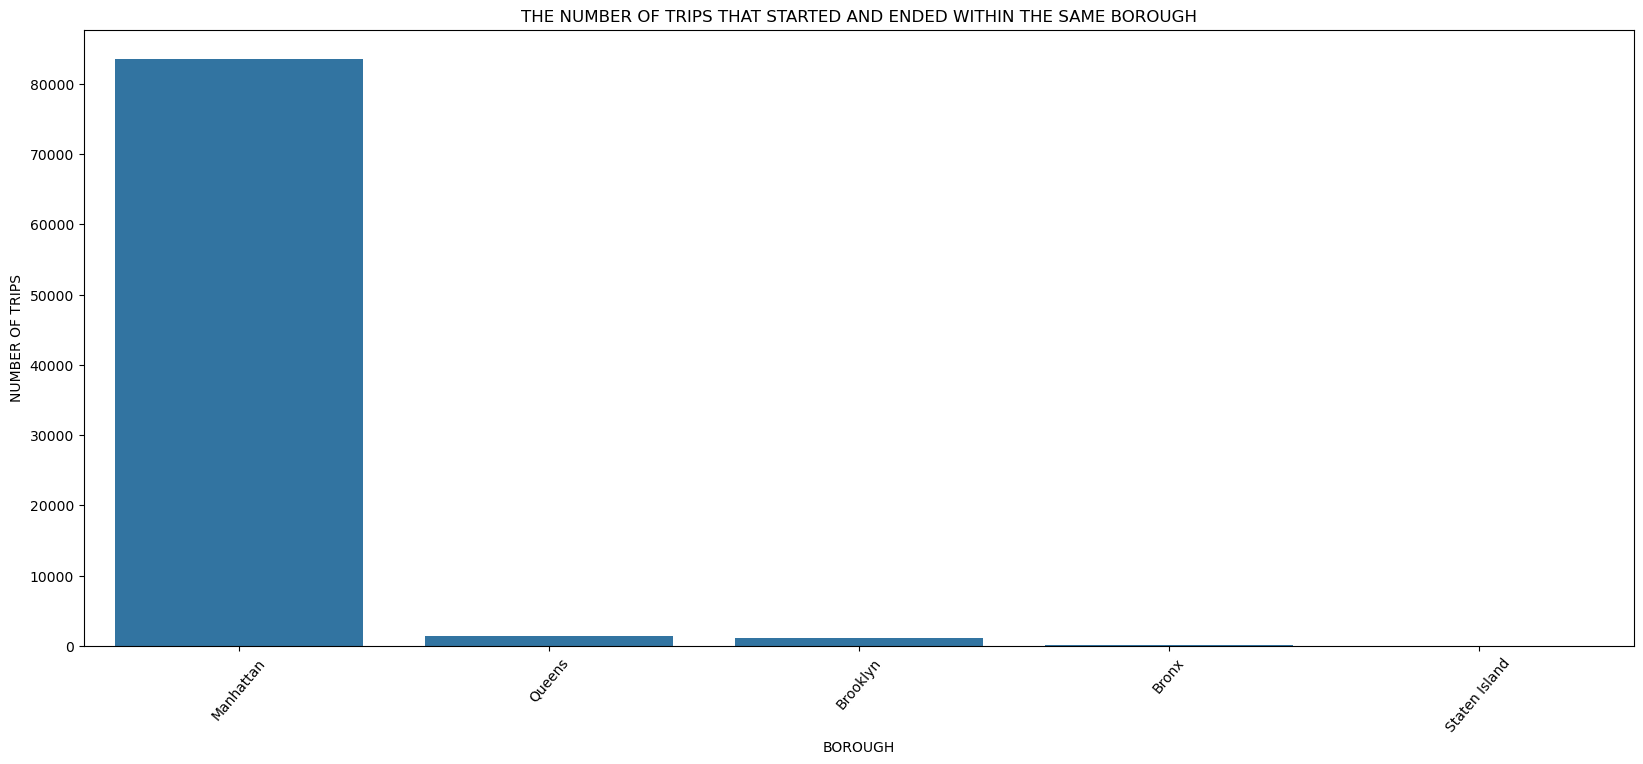

In [42]:
bar_plot(firstQuery,"borough","Number_Of_Trips",
         "borough","number of trips","The number of trips that started and ended within the same borough")

##  2.  The average time it takes for a taxi to find its next fare(trip) per destination borough.

### First, we need to check out Unknown values.

In [44]:
spark.sql("""
SELECT COUNT(*) AS number_of_records
FROM NYCTable
WHERE pickup_borough != "Unknown" AND dropoff_borough != "Unknown"

""").show()

+-----------------+
|number_of_records|
+-----------------+
|            86022|
+-----------------+



In [46]:
spark.sql("""
SELECT COUNT(*)
FROM NYCTable
WHERE pickup_borough = "Unknown" OR dropoff_borough = "Unknown"
""").show()

+--------+
|count(1)|
+--------+
|   12172|
+--------+



In [47]:
spark.sql("""
SELECT COUNT(*)
FROM NYCTable
WHERE pickup_borough = "Unknown" AND dropoff_borough != "Unknown"
""").show()

+--------+
|count(1)|
+--------+
|    6411|
+--------+



In [48]:
filterOut_NulPickUp=spark.sql("""
SELECT *
FROM NYCTable
WHERE pickup_borough != "Unknown"
""")

In [49]:
filterOut_NulPickUp.show(2)

+--------------------+---------+-------------------+-------------------+---------------+-----------------+-------------+------------------+-------------------+--------+--------------+-----------------+---------+--------------+---------------+
|           medallion|rate_code|    pickup_datetime|   dropoff_datetime|passenger_count|trip_time_in_secs|trip_distance|pickUp_date_MilliS|dropOff_date_MilliS|duration|duration_ByMin|borough_area_code|  borough|pickup_borough|dropoff_borough|
+--------------------+---------+-------------------+-------------------+---------------+-----------------+-------------+------------------+-------------------+--------+--------------+-----------------+---------+--------------+---------------+
|002B4CFC5B8920A87...|        1|2013-01-13 17:14:00|2013-01-13 17:21:00|              1|              420|         1.54|     1358097240000|      1358097660000|  420000|           7.0|                1|Manhattan|     Manhattan|      Manhattan|
|00D07524C1482FF5A...|      

In [50]:
filterOut_NulPickUp.createOrReplaceTempView("NYCTableWithoutNull")

In [27]:
# spark.sql("""
# SELECT borough, COUNT(*) AS Number_Of_Trips
# FROM NYCTable
# WHERE pickup_borough IS NOT NULL  AND dropoff_borough IS NULL
# GROUP BY borough
# ORDER BY Number_Of_Trips DESC

# """).show()

In [ ]:
# SELECT 
#     first_name,
#     last_name, 
#     department_name,
#     hire_date, 
#     LEAD(hire_date, 1, 'Not Applicable') OVER (
#         PARTITION by department_name
#         ORDER BY hire_date
#     ) AS hired_next_date

In [51]:
spark.sql("""
SELECT medallion,pickup_borough, dropoff_borough, pickup_datetime,
LEAD(pickup_datetime,1,'Not Applicable') OVER (PARTITION BY medallion ORDER BY pickup_datetime) AS NextPickup_datetime
FROM NYCTableWithoutNull

""").show(10)

+--------------------+--------------+---------------+-------------------+-------------------+
|           medallion|pickup_borough|dropoff_borough|    pickup_datetime|NextPickup_datetime|
+--------------------+--------------+---------------+-------------------+-------------------+
|0F621E366CFE63044...|     Manhattan|      Manhattan|2013-01-13 04:31:00|2013-01-13 06:57:00|
|0F621E366CFE63044...|     Manhattan|      Manhattan|2013-01-13 06:57:00|2013-01-13 07:11:00|
|0F621E366CFE63044...|     Manhattan|      Manhattan|2013-01-13 07:11:00|2013-01-13 08:22:00|
|0F621E366CFE63044...|     Manhattan|      Manhattan|2013-01-13 08:22:00|2013-01-13 09:29:00|
|0F621E366CFE63044...|     Manhattan|      Manhattan|2013-01-13 09:29:00|2013-01-13 10:08:00|
|0F621E366CFE63044...|     Manhattan|      Manhattan|2013-01-13 10:08:00|2013-01-13 10:35:00|
|0F621E366CFE63044...|     Manhattan|      Manhattan|2013-01-13 10:35:00|2013-01-13 10:48:00|
|0F621E366CFE63044...|     Manhattan|      Manhattan|2013-01

In [52]:
WindowFunctionFilteration=spark.sql("""
SELECT medallion,pickup_borough, dropoff_borough, pickup_datetime,
LEAD(pickup_datetime,1,'Not Applicable') OVER (PARTITION BY medallion ORDER BY pickup_datetime) AS NextPickup_datetime
FROM NYCTableWithoutNull

""")

In [53]:
WindowFunctionFilteration.createOrReplaceTempView("WindowFunctionFilterTable")

In [54]:
spark.sql("""
SELECT COUNT(*) FROM 
WindowFunctionFilterTable
""").show()

+--------+
|count(1)|
+--------+
|   91783|
+--------+



In [56]:
spark.sql("""
SELECT pickup_borough, dropoff_borough,pickup_datetime, NextPickup_datetime,
EXTRACT(MINUTE FROM pickup_datetime) AS pickup_byMinutes, EXTRACT(MINUTE FROM NextPickup_datetime) AS NextPickup_byMinutes
FROM 
WindowFunctionFilterTable
""").show()

+--------------+---------------+-------------------+-------------------+----------------+--------------------+
|pickup_borough|dropoff_borough|    pickup_datetime|NextPickup_datetime|pickup_byMinutes|NextPickup_byMinutes|
+--------------+---------------+-------------------+-------------------+----------------+--------------------+
|     Manhattan|      Manhattan|2013-01-13 04:31:00|2013-01-13 06:57:00|              31|                  57|
|     Manhattan|      Manhattan|2013-01-13 06:57:00|2013-01-13 07:11:00|              57|                  11|
|     Manhattan|      Manhattan|2013-01-13 07:11:00|2013-01-13 08:22:00|              11|                  22|
|     Manhattan|      Manhattan|2013-01-13 08:22:00|2013-01-13 09:29:00|              22|                  29|
|     Manhattan|      Manhattan|2013-01-13 09:29:00|2013-01-13 10:08:00|              29|                   8|
|     Manhattan|      Manhattan|2013-01-13 10:08:00|2013-01-13 10:35:00|               8|                  35|
|

In [57]:
WindowFunctionFinalResult=spark.sql(""" SELECT medallion, pickup_borough, dropoff_borough,pickup_datetime, NextPickup_datetime,
EXTRACT(MINUTE FROM pickup_datetime) AS pickup_byMinutes, EXTRACT(MINUTE FROM NextPickup_datetime) AS NextPickup_byMinutes
FROM 
WindowFunctionFilterTable
""")

In [58]:
from pyspark.sql.functions import avg,col

In [59]:
WindowFunctionFinalResult.withColumn("diff_min", col("NextPickup_byMinutes") - col("pickup_byMinutes"))\
.show(5)


+--------------------+--------------+---------------+-------------------+-------------------+----------------+--------------------+--------+
|           medallion|pickup_borough|dropoff_borough|    pickup_datetime|NextPickup_datetime|pickup_byMinutes|NextPickup_byMinutes|diff_min|
+--------------------+--------------+---------------+-------------------+-------------------+----------------+--------------------+--------+
|0F621E366CFE63044...|     Manhattan|      Manhattan|2013-01-13 04:31:00|2013-01-13 06:57:00|              31|                  57|      26|
|0F621E366CFE63044...|     Manhattan|      Manhattan|2013-01-13 06:57:00|2013-01-13 07:11:00|              57|                  11|     -46|
|0F621E366CFE63044...|     Manhattan|      Manhattan|2013-01-13 07:11:00|2013-01-13 08:22:00|              11|                  22|      11|
|0F621E366CFE63044...|     Manhattan|      Manhattan|2013-01-13 08:22:00|2013-01-13 09:29:00|              22|                  29|       7|
|0F621E366CFE

In [60]:
WindowFunctionFinalResult = WindowFunctionFinalResult.withColumn("diff_min", col("NextPickup_byMinutes") - col("pickup_byMinutes"))\
.filter(col("diff_min") > 0) 

In [61]:
WindowFunctionFinalResult.groupBy("pickup_borough","dropoff_borough")\
.agg(round(avg("diff_min")).alias("avg_wait_time")).orderBy("pickup_borough").show()

+--------------+---------------+-------------+
|pickup_borough|dropoff_borough|avg_wait_time|
+--------------+---------------+-------------+
|         Bronx|          Bronx|         13.0|
|         Bronx|        Unknown|         21.0|
|      Brooklyn|        Unknown|         23.0|
|      Brooklyn|       Brooklyn|         19.0|
|     Manhattan|        Unknown|         16.0|
|     Manhattan|      Manhattan|         16.0|
|        Queens|        Unknown|         24.0|
|        Queens|         Queens|         19.0|
| Staten Island|  Staten Island|         31.0|
+--------------+---------------+-------------+

